In [6]:
import pandas as pd
import numpy as np

# Extensive country mapping dictionary
country_mapping = {
    '3P': 'All Countries Excluding Residents',
    'TW': 'Chinese Taipei',
    '5R': 'Developed Countries',
    'AM': 'Armenia',
    'TJ': 'Tajikistan',
    'JP': 'Japan',
    'SG': 'Singapore',
    'SA': 'Saudi Arabia',
    'LU': 'Luxembourg',
    'FI': 'Finland',
    'PK': 'Pakistan',
    'IT': 'Italy',
    'SE': 'Sweden',
    'DE': 'Germany',
    'FR': 'France',
    'US': 'United States',
    'UK': 'United Kingdom',
    'IN': 'India',
    'CN': 'China',
    'BR': 'Brazil',
    'RU': 'Russia',
    'CA': 'Canada',
    'AU': 'Australia',
    'ZA': 'South Africa',
    'AE': 'United Arab Emirates',
    'AR': 'Argentina',
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'CH': 'Switzerland',
    'CL': 'Chile',
    'CO': 'Colombia',
    'CZ': 'Czech Republic',
    'DK': 'Denmark',
    'EG': 'Egypt',
    'ES': 'Spain',
    'GR': 'Greece',
    'HU': 'Hungary',
    'ID': 'Indonesia',
    'IE': 'Ireland',
    'IL': 'Israel',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'MY': 'Malaysia',
    'NL': 'Netherlands',
    'NO': 'Norway',
    'NZ': 'New Zealand',
    'PH': 'Philippines',
    'PL': 'Poland',
    'PT': 'Portugal',
    'QA': 'Qatar',
    'RO': 'Romania',
    'SK': 'Slovakia',
    'TH': 'Thailand',
    'TR': 'Turkey',
    'VN': 'Vietnam',
    'HK': 'Hong Kong',
    'NG': 'Nigeria',
    'KE': 'Kenya',
    'GH': 'Ghana',
    'SI': 'Slovenia',
    'IS': 'Iceland',
    'HR': 'Croatia',
    'CY': 'Cyprus',
    'LT': 'Lithuania',
    'LV': 'Latvia',
    'EE': 'Estonia',
    'MT': 'Malta',
}

# Abbreviation mapping for other columns (e.g., 'G', 'I', etc.)
abbreviation_mapping = {
    'G': 'Gross Issues',
    'I': 'Amounts Outstanding',
    'C': 'Net Issues',
}

# Load the dataset
file_path = r'D:\Data\23-24\Financial\WS_DEBT_SEC2_PUB_csv_col.csv'
data = pd.read_csv(file_path)

# Replace abbreviations with full descriptions
columns_to_expand = ['MEASURE', 'COLLECTION', 'Collateral']
for col in columns_to_expand:
    if col in data.columns:
        data[col] = data[col].map(abbreviation_mapping)

# Drop empty or irrelevant columns
columns_to_drop = ['COLLECTION']  # Drop empty column
data.drop(columns=columns_to_drop, inplace=True)

# Replace country abbreviations with full names
if 'ISSUER_RES' in data.columns:
    data['ISSUER_RES'] = data['ISSUER_RES'].map(country_mapping)

# Remove rows with unmapped or "unknown" countries
data = data.dropna(subset=['ISSUER_RES'])

# Identify time-series columns
time_series_columns = [col for col in data.columns if col.endswith(('Q1', 'Q2', 'Q3', 'Q4'))]

# Handle missing values in time-series columns
data['Missing_Flag'] = data[time_series_columns].isnull().any(axis=1)

# Group-wise mean imputation by country
if 'ISSUER_RES' in data.columns:
    for col in time_series_columns:
        data[col] = data.groupby('ISSUER_RES')[col].transform(lambda group: group.fillna(group.mean()))

# Interpolation for smooth transitions
data[time_series_columns] = data[time_series_columns].interpolate(method='linear', axis=1)

# Forward and backward fill for remaining missing values
for col in time_series_columns:
    data[col] = data[col].ffill()  # Forward fill
    data[col] = data[col].bfill()  # Backward fill


# Normalize time-series columns
for col in time_series_columns:
    max_value = data[col].max()
    if max_value > 0:
        data[col] = data[col] / max_value

# Define exchange rates for currency conversion
exchange_rates = {
    'USD': 1, 'EUR': 1.1, 'GBP': 1.3, 'JPY': 0.008, 'CNY': 0.15,
    'AUD': 0.74, 'CAD': 0.79, 'INR': 0.012, 'BRL': 0.19, 'MXN': 0.05
}

# Convert monetary values in all time-series columns to USD
if 'ISSUE_CUR' in data.columns:
    for col in time_series_columns:
        data[col] = data.apply(
            lambda row: row[col] * exchange_rates.get(row['ISSUE_CUR'], np.nan),
            axis=1
        )
    data['ISSUE_CUR'] = 'USD'  # Update currency column to reflect USD

# Columns to retain based on project objectives
important_columns = [
    'ISSUER_RES',  # Country
    'ISSUE_CUR',   # Currency
    'MEASURE',     # Measure type
] + time_series_columns  # Add time-series columns dynamically

# Drop irrelevant columns
data = data[important_columns]

# Save the cleaned and normalized dataset
cleaned_file_path = r'D:\Data\23-24\Financial\Cleaned_WS_DEBT_SEC2_PUB_with_Missing_Handled.csv'
data.to_csv(cleaned_file_path, index=False)
print(f"Cleaned dataset saved to {cleaned_file_path}")

# Final Snapshot
print("\nFinal Cleaned Data Snapshot:")
print(data.head())


Cleaned dataset saved to D:\Data\23-24\Financial\Cleaned_WS_DEBT_SEC2_PUB_with_Missing_Handled.csv

Final Cleaned Data Snapshot:
                          ISSUER_RES ISSUE_CUR              MEASURE   1962-Q4  \
0  All Countries Excluding Residents       USD           Net Issues       NaN   
1                     Chinese Taipei       USD  Amounts Outstanding  0.753304   
2                Developed Countries       USD           Net Issues       NaN   
3                            Armenia       USD         Gross Issues       NaN   
4                            Armenia       USD  Amounts Outstanding       NaN   

    1963-Q1   1963-Q2   1963-Q3   1963-Q4   1964-Q1   1964-Q2  ...   2022-Q1  \
0       NaN       NaN       NaN       NaN       NaN       NaN  ...       NaN   
1  0.504425  0.504425  0.504425  0.504425  0.504425  0.504425  ...  0.000036   
2       NaN       NaN       NaN       NaN       NaN       NaN  ...       NaN   
3       NaN       NaN       NaN       NaN       NaN       NaN  .

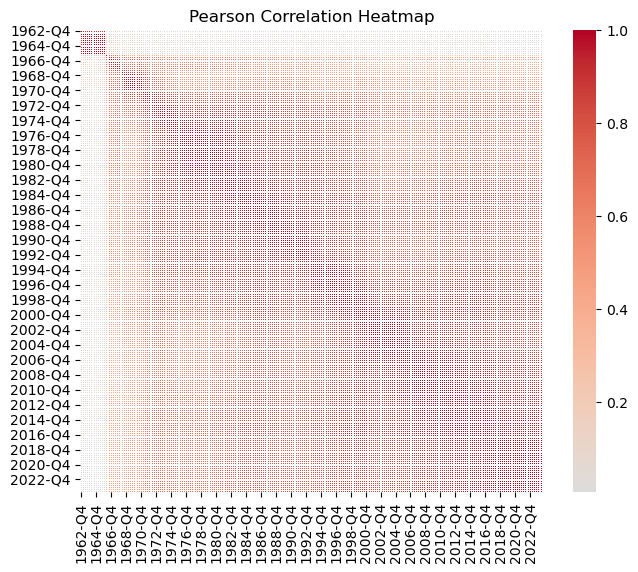

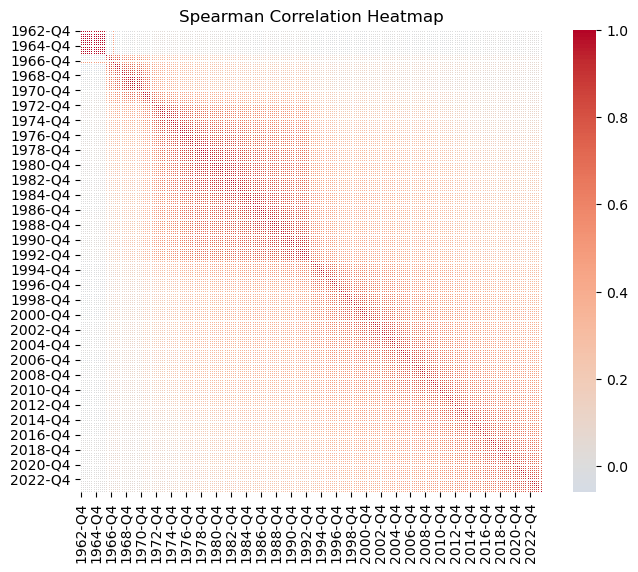

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
file_path = r"D:\Data\23-24\Financial\Cleaned_WS_DEBT_SEC2_PUB_with_Missing_Handled.csv"
data = pd.read_csv(file_path)

# Identify time-series columns dynamically (columns ending with Q1, Q2, Q3, or Q4)
time_series_columns = [col for col in data.columns if col.endswith(('Q1', 'Q2', 'Q3', 'Q4'))]

# Select only the time-series data
time_series_data = data[time_series_columns]

# Ensure there are no NaN values (correlation requires complete data)
time_series_data = time_series_data.dropna()

# Calculate the correlation matrices
pearson_corr = time_series_data.corr(method='pearson')
spearman_corr = time_series_data.corr(method='spearman')

# Save the correlation matrices to CSV files
pearson_corr.to_csv(r"D:\Data\23-24\Financial\pearson_correlation_matrix.csv")
spearman_corr.to_csv(r"D:\Data\23-24\Financial\spearman_correlation_matrix.csv")

# Plot Pearson Correlation Heatmap
plt.figure(figsize=(8, 6))  # Adjusted for better visibility
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Pearson Correlation Heatmap")
plt.show()

# Plot Spearman Correlation Heatmap
plt.figure(figsize=(8, 6))  # Adjusted for better visibility
sns.heatmap(spearman_corr, cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.title("Spearman Correlation Heatmap")
plt.show()
